In [1]:
import os
import h2o
import pandas as pd
import numpy as np
import datetime as dt
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.estimators import H2ONaiveBayesEstimator

In [2]:
from h2o.estimators import H2OXGBoostEstimator

In [3]:
import matplotlib.pylab as plt
%matplotlib inline

In [39]:
h2o.cluster().shutdown()

In [10]:
h2o.init(nthreads = -1, max_mem_size = 25)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_131"; OpenJDK Runtime Environment (build 1.8.0_131-8u131-b11-2ubuntu1.16.04.3-b11); OpenJDK 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /home/laith/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpu0851snw
  JVM stdout: /tmp/tmpu0851snw/h2o_laith_started_from_python.out
  JVM stderr: /tmp/tmpu0851snw/h2o_laith_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster version:,3.14.0.7
H2O cluster version age:,17 days
H2O cluster name:,H2O_from_python_laith_g68owb
H2O cluster total nodes:,1
H2O cluster free memory:,22.22 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [27]:
train = h2o.import_file(os.path.realpath("../data/train2.csv"))
test  = h2o.import_file(os.path.realpath("../data/test2.csv"))

x = train.columns
y = "target"
x.remove(y)

test_id = test['id'].as_data_frame(True).id.values

features_bin = [i for i in x if set(i)&set('bin')==set('bin')]
features_cat = [i for i in x if (set(i)&set('cat')==set('cat'))&(set(i)&set('avg')==set(''))]
features_con = list(set(x) - (set(features_bin)|set(features_cat)))


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
[i for i in x if (set(i)&set('cat')==set('cat'))&(set(i)&set('avg')!=set('avg'))]


['ps_ind_05_cat',
 'ps_car_01_cat',
 'ps_car_07_cat',
 'ps_car_03_cat',
 'ps_car_06_cat',
 'ps_car_04_cat',
 'ps_car_09_cat',
 'ps_car_02_cat',
 'ps_ind_02_cat',
 'ps_car_05_cat',
 'ps_car_08_cat',
 'ps_ind_04_cat',
 'ps_reg_01_plus_ps_car_02_cat',
 'ps_reg_01_plus_ps_car_04_cat']

In [35]:
def prepare_data(with_validation = True):
    train = h2o.import_file(os.path.realpath("../data/train2.csv"))
    test  = h2o.import_file(os.path.realpath("../data/test2.csv"))
    
    x = train.columns
    y = "target"
    x.remove(y)
    
    test_id = test['id'].as_data_frame(True).id.values
    
    features_bin = [i for i in x if set(i)&set('bin')==set('bin')]
    features_cat = [i for i in x if (set(i)&set('cat')==set('cat'))&(set(i)&set('avg')!=set('avg'))]
    features_con = list(set(x) - (set(features_bin)|set(features_cat)))
    
    train[features_cat] = train[features_cat].asfactor()
    train[features_bin] = train[features_bin].asfactor()
    train[features_con] = train[features_con].asnumeric()
    
    test[features_cat] = test[features_cat].asfactor()
    test[features_bin] = test[features_bin].asfactor()
    test[features_con] = test[features_con].asnumeric()
    
    train['target'] = train['target'].asfactor()
    
    return train, test, x, y, test_id
    

In [36]:
train, test, x, y, test_id = prepare_data(with_validation = True)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
nfolds = 5

In [37]:
my_gbm = H2OGradientBoostingEstimator(distribution="bernoulli",
                                      ntrees=100,
                                      max_depth=27,
                                      min_rows=2048,
                                      learn_rate=0.2,
                                      sample_rate=0.37,
                                      col_sample_rate=0.63,
                                      col_sample_rate_per_tree=0.85,
                                      col_sample_rate_change_per_level=1.0,
                                      nbins=128,
                                      nbins_cats=4096,
                                      min_split_improvement=0.0,
                                      histogram_type='RoundRobin',
                                      nfolds=nfolds,
                                      fold_assignment="Modulo",
                                      keep_cross_validation_predictions=True,
                                      seed=1)
my_gbm.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [38]:
my_gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1510019598591_170


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.033984094636136976
RMSE: 0.1843477546273265
LogLoss: 0.14417417673490698
Mean Per-Class Error: 0.3346685712802413
AUC: 0.7281206830858074
Gini: 0.4562413661716147
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.079346896191179: 


,0,1,Error,Rate
0,538792.0,34726.0,0.0605,(34726.0/573518.0)
1,16354.0,5340.0,0.7538,(16354.0/21694.0)
Total,555146.0,40066.0,0.0858,(51080.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0793469,0.1729275,163.0
max f2,0.0520048,0.2590653,225.0
max f0point5,0.1066241,0.1656448,122.0
max accuracy,0.3201513,0.9635810,16.0
max precision,0.3851384,0.76,8.0
max recall,0.0043954,1.0,397.0
max specificity,0.5515620,0.9999983,0.0
max absolute_mcc,0.0633855,0.1435390,195.0
max min_per_class_accuracy,0.0381870,0.6642851,268.0
max mean_per_class_accuracy,0.0391067,0.6653314,265.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.1363046,6.4616611,6.4616611,0.2355115,0.2355115,0.0646262,0.0646262,546.1661058,546.1661058
,2,0.0200013,0.1145869,4.0426739,5.2522691,0.1473454,0.1914322,0.0404259,0.1050521,304.2673926,425.2269087
,3,0.0300011,0.1025694,3.5540497,4.6862277,0.1295363,0.1708014,0.0355398,0.1405919,255.4049711,368.6227662
,4,0.0400009,0.0942272,3.1391801,4.2994820,0.1144153,0.1567054,0.0313912,0.1719830,213.9180095,329.9482015
,5,0.0500007,0.0879624,2.8672100,4.0130372,0.1045027,0.1462652,0.0286715,0.2006546,186.7210013,301.3037240
,6,0.1000013,0.0692150,2.3563802,3.1847087,0.0858842,0.1160747,0.1178206,0.3184752,135.6380240,218.4708740
,7,0.1500003,0.0586817,1.8641475,2.7445315,0.0679435,0.1000314,0.0932055,0.4116806,86.4147475,174.4531512
,8,0.2000010,0.0515554,1.5902801,2.4559662,0.0579618,0.0895139,0.0795151,0.4911957,59.0280092,145.5966233
,9,0.3000007,0.0417493,1.2275325,2.0464906,0.0447405,0.0745895,0.1227528,0.6139486,22.7532474,104.6490606
,10,0.4000003,0.0349280,1.0136477,1.7882810,0.0369449,0.0651784,0.1013644,0.7153130,1.3647732,78.8280972




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.03496371397441792
RMSE: 0.1869858657075928
LogLoss: 0.15441540009850316
Mean Per-Class Error: 0.4148099889665947
AUC: 0.6175420015199719
Gini: 0.2350840030399437
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.058805335844667496: 


,0,1,Error,Rate
0,491707.0,81811.0,0.1426,(81811.0/573518.0)
1,15918.0,5776.0,0.7338,(15918.0/21694.0)
Total,507625.0,87587.0,0.1642,(97729.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0588053,0.1057091,201.0
max f2,0.0347355,0.1883046,277.0
max f0point5,0.0850699,0.0872286,145.0
max accuracy,0.6925635,0.9635508,0.0
max precision,0.4131544,0.3333333,8.0
max recall,0.0022372,1.0,399.0
max specificity,0.6925635,0.9999983,0.0
max absolute_mcc,0.0473635,0.0673714,234.0
max min_per_class_accuracy,0.0338025,0.5833871,281.0
max mean_per_class_accuracy,0.0338025,0.5851900,281.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.1318583,3.1248261,3.1248261,0.1138922,0.1138922,0.0312529,0.0312529,212.4826104,212.4826104
,2,0.0200013,0.1113522,2.3878051,2.7563466,0.0870296,0.1004620,0.0238776,0.0551305,138.7805124,175.6346568
,3,0.0300011,0.1000469,1.8715229,2.4614219,0.0682124,0.0897127,0.0187149,0.0738453,87.1522935,146.1421874
,4,0.0400009,0.0922206,1.8761326,2.3151057,0.0683804,0.0843799,0.0187609,0.0926063,87.6132597,131.5105700
,5,0.0500007,0.0863152,2.0328611,2.2586587,0.0740927,0.0823225,0.0203282,0.1129345,103.2861119,125.8658681
,6,0.1000013,0.0683263,1.6372971,1.9479779,0.0596754,0.0709990,0.0818660,0.1948004,63.7297068,94.7977874
,7,0.1500003,0.0581391,1.5110473,1.8023376,0.0550739,0.0656907,0.0755508,0.2703512,51.1047335,80.2337624
,8,0.2000010,0.0511858,1.3395229,1.6866330,0.0488223,0.0614736,0.0669770,0.3373283,33.9522883,68.6632967
,9,0.3000007,0.0415793,1.1957263,1.5229983,0.0435813,0.0555095,0.1195722,0.4569005,19.5726337,52.2998340
,10,0.4000003,0.0347885,1.0611265,1.4075309,0.0386754,0.0513010,0.1061123,0.5630128,6.1126457,40.7530854



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8265877,0.0220306,0.8682073,0.8345724,0.8427194,0.8115623,0.7758774
auc,0.6175691,0.0024692,0.6171947,0.6239794,0.6158515,0.6173416,0.6134782
err,0.1734122,0.0220306,0.1317927,0.1654276,0.1572806,0.1884377,0.2241226
err_count,20643.4,2622.5352,15689.0,19693.0,18723.0,22432.0,26680.0
f0point5,0.0781223,0.0020707,0.0811909,0.0800795,0.0785766,0.0780661,0.0726983
f1,0.1067468,0.0014467,0.1060908,0.1092768,0.1061727,0.1086386,0.1035549
f2,0.1694280,0.0070919,0.1530193,0.1719818,0.1636449,0.1785714,0.1799225
lift_top_group,3.1388187,0.1469255,3.4482324,3.2725856,3.129951,2.8590188,2.984306
logloss,0.1544154,0.0006155,0.1531077,0.1537213,0.1546678,0.1553251,0.1552551
max_per_class_error,0.7163328,0.0331931,0.7829837,0.7214664,0.7439558,0.6871854,0.6460726


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-11-07 03:33:11,4 min 48.942 sec,0.0,0.1874009,0.1564850,0.5,1.0,0.9635525
,2017-11-07 03:33:12,4 min 50.120 sec,1.0,0.1871565,0.1552321,0.6141815,1.9872232,0.1517375
,2017-11-07 03:33:12,4 min 50.530 sec,2.0,0.1869539,0.1542612,0.6279385,2.6797822,0.1680779
,2017-11-07 03:33:13,4 min 51.346 sec,3.0,0.1868145,0.1536090,0.6348566,2.9827315,0.1512503
,2017-11-07 03:33:14,4 min 52.247 sec,4.0,0.1866908,0.1530483,0.6400460,3.1114270,0.1415613
,2017-11-07 03:33:15,4 min 53.176 sec,5.0,0.1865776,0.1525560,0.6434592,3.3454907,0.1373847
,2017-11-07 03:33:22,4 min 59.705 sec,22.0,0.1858738,0.1496622,0.6724275,4.3507903,0.1042234
,2017-11-07 03:33:34,5 min 12.186 sec,53.0,0.1852187,0.1472278,0.6982537,5.1849991,0.1066578
,2017-11-07 03:33:53,5 min 31.446 sec,100.0,0.1843478,0.1441742,0.7281207,6.4616611,0.0858182


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ps_reg_01_plus_ps_car_04_cat,406.4349365,1.0,0.2161171
ps_car_06_cat,200.7972260,0.4940452,0.1067716
ps_car_13,191.3916168,0.4709035,0.1017703
ps_reg_01_plus_ps_car_02_cat,142.1145172,0.3496612,0.0755678
ps_car_01_cat,103.2764740,0.2541033,0.0549161
---,---,---,---
ps_car_04_cat_avg,1.1248965,0.0027677,0.0005982
ps_car_02_cat_avg,1.1166131,0.0027473,0.0005937
ps_car_02_cat,0.9194434,0.0022622,0.0004889
ps_ind_12_bin,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [27]:
my_gbm.gini()

0.5082102957884913

In [16]:
my_gbm.auc()

0.7541051478942457

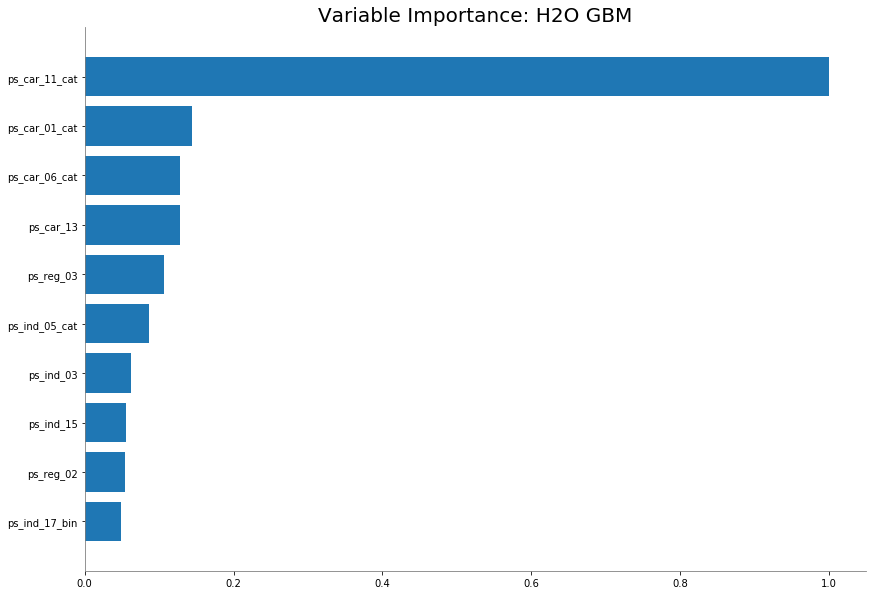

In [29]:
my_gbm.varimp_plot()

In [65]:
import math
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(22,27,1)),
                    'sample_rate': [x/100. for x in range(20,101)],
                    'col_sample_rate_per_tree': [x/100. for x in range(60,101)],
                    'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                    'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                    'nbins': [2**x for x in range(4,10)],
                    'nbins_cats': [2**x for x in range(8,13)],
                    'min_split_improvement': [0,1e-8,1e-6,1e-4],
                    'histogram_type': ["QuantilesGlobal","RoundRobin",'UniformAdaptive','Random']}

search_criteria_tune = {'strategy': "RandomDiscrete",
                       'max_runtime_secs': 60*60*8,  ## limit the runtime to 60 minutes
                       'max_models': 200,  ## build no more than 100 models
                       'seed' : 1234,
                       'stopping_rounds' : 5,
                       'stopping_metric' : "AUC",
                       'stopping_tolerance': 1e-3
                       }

In [66]:
my_rdf= H2ORandomForestEstimator(binomial_double_trees=True,
                                 nfolds=nfolds,
                                 fold_assignment="Stratified",
                                 keep_cross_validation_predictions=True,
                                 stopping_rounds = 5,
                                 stopping_metric = "AUC",
                                 stopping_tolerance = 1e-4,
                                 seed=1)

In [67]:
final_grid = H2OGridSearch(my_rdf, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
final_grid.train(x=x, y=y, training_frame=train)

drf Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: col_sample_rate_change_per_level, 0.91
Hyper-parameter: col_sample_rate_per_tree, 1.0
Hyper-parameter: histogram_type, Random
Hyper-parameter: max_depth, 23
Hyper-parameter: min_rows, 262144.0
Hyper-parameter: min_split_improvement, 1e-06
Hyper-parameter: nbins, 16
Hyper-parameter: nbins_cats, 2048
Hyper-parameter: sample_rate, 0.61
failure_details: Illegal argument(s) for DRF model: final_grid_model_12.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=262144.0: must have at least 524288.0 (weighted) rows, but have only 476591.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=262144.0: must have at least 524288.0 (weighted) rows, but have only 476339.0.
ERRR on field: _min_rows: The dataset size is too small to split for min_rows=262144.0: must have at least 524288.0 (weighted) 

In [70]:
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

In [80]:
sorted_final_grid

      col_sample_rate_change_per_level col_sample_rate_per_tree  \
0                                 0.92                      0.9   
1                                 1.02                     0.85   
2                                 1.04                     0.95   
3                                 1.01                     0.99   
4                                 1.02                     0.79   
5                                 0.99                      1.0   
6                                 0.94                     0.65   
7                                 1.05                     0.88   
8                                 1.02                     0.89   
9                                 1.08                     0.63   
10                                1.05                     0.97   
11                                1.05                     0.88   
12                                0.94                     0.63   
13                                 0.9                     0.9

[70 rows x 12 columns]


In [72]:
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])

In [83]:
my_rdf= H2ORandomForestEstimator(binomial_double_trees=True,
                                 max_depth=23,
                                 min_rows=256,
                                 min_split_improvement=0,
                                 nbins=32,
                                 nbins_cats=1024,
                                 sample_rate=0.99,
                                 col_sample_rate_change_per_level=0.92,
                                 col_sample_rate_per_tree=0.9,
                                 histogram_type='RoundRobin',
                                 nfolds=nfolds,
                                 fold_assignment="Modulo",
                                 keep_cross_validation_predictions=True,
                                 stopping_rounds = 5,
                                 stopping_metric = "AUC",
                                 stopping_tolerance = 1e-4,
                                 seed=1)
my_rdf.train(x=x, y=y, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [84]:
my_rdf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1509234555216_13641


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.03530859637047687
RMSE: 0.1879058178196643
LogLoss: 0.16085840877783458
Mean Per-Class Error: 0.43661764093759303
AUC: 0.5869001214614877
Gini: 0.17380024292297547
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05673730037073246: 


,0,1,Error,Rate
0,194607.0,31239.0,0.1383,(31239.0/225846.0)
1,6576.0,2034.0,0.7638,(6576.0/8610.0)
Total,201183.0,33273.0,0.1613,(37815.0/234456.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0567373,0.0971277,165.0
max f2,0.0340894,0.1761752,259.0
max f0point5,0.0736991,0.0748483,114.0
max accuracy,0.2296377,0.9632724,0.0
max precision,0.1935382,0.4,2.0
max recall,0.0,1.0,399.0
max specificity,0.2296377,0.9999911,0.0
max absolute_mcc,0.0567373,0.0527745,165.0
max min_per_class_accuracy,0.0350227,0.5599037,255.0
max mean_per_class_accuracy,0.0340894,0.5633824,259.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.0788738,5.8071990,5.8071990,0.2116580,0.2116580,0.0580806,0.0580806,480.7198953,480.7198953
,2,0.0200013,0.0716358,4.0933802,4.9503616,0.1491935,0.1804284,0.0409330,0.0990136,309.3380212,395.0361562
,3,0.0300011,0.0674308,3.7799232,4.5602373,0.1377688,0.1662093,0.0377985,0.1368120,277.9923169,356.0237279
,4,0.0400009,0.0643628,3.2590313,4.2349495,0.1187836,0.1543534,0.0325897,0.1694017,225.9031318,323.4949452
,5,0.0500007,0.0619731,3.0884738,4.0056620,0.1125672,0.1459964,0.0308841,0.2002858,208.8473809,300.5662028
,6,0.1000013,0.0541462,2.4808369,3.2432495,0.0904203,0.1182084,0.1240435,0.3243293,148.0836943,224.3249485
,7,0.1500003,0.0493419,2.1416492,2.8760576,0.0780578,0.1048252,0.1070803,0.4314096,114.1649152,187.6057600
,8,0.2000010,0.0458793,1.7138149,2.5854945,0.0624643,0.0942349,0.0856919,0.5171015,71.3814893,158.5494482
,9,0.3000007,0.0408555,1.3515303,2.1741754,0.0492599,0.0792433,0.1351526,0.6522541,35.1530309,117.4175395
,10,0.4000003,0.0371265,0.9956704,1.8795504,0.0362897,0.0685049,0.0995667,0.7518208,-0.4329650,87.9550371




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.03482308997743171
RMSE: 0.18660945843507426
LogLoss: 0.1526803942909237
Mean Per-Class Error: 0.40563381742836535
AUC: 0.6320304779070305
Gini: 0.26406095581406097
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05267112225883115: 


,0,1,Error,Rate
0,511316.0,62202.0,0.1085,(62202.0/573518.0)
1,16680.0,5014.0,0.7689,(16680.0/21694.0)
Total,527996.0,67216.0,0.1325,(78882.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0526711,0.1127882,142.0
max f2,0.0402720,0.1956690,216.0
max f0point5,0.0661198,0.0937531,86.0
max accuracy,0.1321680,0.9635508,0.0
max precision,0.1022925,0.1831395,13.0
max recall,0.0122662,1.0,398.0
max specificity,0.1321680,0.9999983,0.0
max absolute_mcc,0.0432083,0.0761785,196.0
max min_per_class_accuracy,0.0368850,0.5929289,241.0
max mean_per_class_accuracy,0.0368850,0.5943662,241.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.0778017,3.2308305,3.2308305,0.1177558,0.1177558,0.0323131,0.0323131,223.0830529,223.0830529
,2,0.0200013,0.0709673,2.4385114,2.8347042,0.0888777,0.1033179,0.0243846,0.0566977,143.8511410,183.4704246
,3,0.0300011,0.0669932,2.3048312,2.6580898,0.0840054,0.0968808,0.0230478,0.0797456,130.4831201,165.8089789
,4,0.0400009,0.0640017,2.0789577,2.5133129,0.0757728,0.0916040,0.0207892,0.1005347,107.8957743,151.3312858
,5,0.0500007,0.0616470,1.9775452,2.4061629,0.0720766,0.0876987,0.0197751,0.1203098,97.7545170,140.6162921
,6,0.1000013,0.0539497,1.7921765,2.0991697,0.0653204,0.0765095,0.0896100,0.2099198,79.2176521,109.9169721
,7,0.1500003,0.0492846,1.5184228,1.9055917,0.0553427,0.0694541,0.0759196,0.2858394,51.8422795,90.5591749
,8,0.2000010,0.0458691,1.3607266,1.7693743,0.0495951,0.0644893,0.0680372,0.3538766,36.0726617,76.9374322
,9,0.3000007,0.0409223,1.2381345,1.5922954,0.0451269,0.0580352,0.1238130,0.4776897,23.8134519,59.2295379
,10,0.4000003,0.0371982,1.0311642,1.4520132,0.0375834,0.0529223,0.1031161,0.5808058,3.1164154,45.2013162



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8697456,0.0072583,0.8582613,0.8678545,0.8848305,0.8779002,0.8598814
auc,0.6320995,0.0026186,0.6350407,0.6368893,0.632322,0.6297507,0.6264948
err,0.1302544,0.0072583,0.1417387,0.1321455,0.1151694,0.1220998,0.1401186
err_count,15505.8,864.06287,16873.0,15731.0,13710.0,14535.0,16680.0
f0point5,0.0874616,0.0021835,0.0859047,0.0892964,0.0906823,0.0892755,0.0821490
f1,0.1136790,0.0019486,0.1142317,0.1167818,0.1145699,0.1143136,0.1084981
f2,0.1626574,0.0041303,0.1704314,0.1687107,0.1555431,0.1588700,0.1597318
lift_top_group,3.2544043,0.2349898,3.6113245,3.664374,3.198994,2.881891,2.9154377
logloss,0.1526804,0.0005969,0.1512419,0.1523858,0.1527617,0.1536399,0.1533727
max_per_class_error,0.7709178,0.0124843,0.7463869,0.7602029,0.7957633,0.7853547,0.7668810


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2017-10-29 12:02:00,6 min 5.992 sec,0.0,nan,nan,nan,nan,nan
,2017-10-29 12:02:02,6 min 7.439 sec,1.0,0.1886341,0.1629365,0.5975824,3.3829238,0.0709051
,2017-10-29 12:02:03,6 min 8.573 sec,2.0,0.1938897,0.1703525,0.5887558,4.0742570,0.0739167
,2017-10-29 12:02:04,6 min 9.827 sec,3.0,0.1910683,0.1655660,0.5800537,4.6134969,0.1077606
,2017-10-29 12:02:11,6 min 16.997 sec,11.0,0.1866343,0.1625386,0.5847768,5.4292701,0.1373613
,2017-10-29 12:02:31,6 min 36.757 sec,32.0,0.1879265,0.1620380,0.5862762,5.6366701,0.1543821
,2017-10-29 12:02:49,6 min 54.896 sec,50.0,0.1879058,0.1608584,0.5869001,5.8071990,0.1612883


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
ps_car_11_cat,5423.3886719,1.0,0.1851469
ps_ind_05_cat,2037.6219482,0.3757101,0.0695616
ps_car_13,1942.5847168,0.3581865,0.0663171
ps_ind_17_bin,1401.5368652,0.2584246,0.0478465
ps_reg_03,1335.0637207,0.2461678,0.0455772
---,---,---,---
ps_ind_12_bin,7.6879830,0.0014176,0.0002625
ps_car_10_cat,1.0008702,0.0001845,0.0000342
ps_ind_11_bin,0.1216903,0.0000224,0.0000042
ps_ind_10_bin,0.0,0.0,0.0



See the whole table with table.as_data_frame()


In [93]:
my_nbe = H2ONaiveBayesEstimator(laplace=3,
                                compute_metrics=True,
                                nfolds=nfolds,
                                fold_assignment="Modulo",
                                keep_cross_validation_predictions=True,
                                seed=1)
my_nbe.train(x=x, y=y, training_frame=train)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


In [100]:
my_nbe.gini()

0.2352899015847476

In [95]:
ensemble = H2OStackedEnsembleEstimator(model_id="my_ensemble_binomial_third",
                                       base_models=[my_gbm.model_id, my_rdf.model_id,my_nbe.model_id])
ensemble.train(x=x, y=y, training_frame=train)

stackedensemble Model Build progress: |███████████████████████████████████| 100%


In [97]:
ensemble

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  my_ensemble_binomial_third
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.03399206503785317
RMSE: 0.18436937120317237
LogLoss: 0.1445988564503525
Null degrees of freedom: 595211
Residual degrees of freedom: 595209
Null deviance: 186283.45504691734
Residual deviance: 172133.94909105444
AIC: 172139.94909105444
AUC: 0.7593889296063765
Gini: 0.518777859212753
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05933166636628491: 


,0,1,Error,Rate
0,528485.0,45033.0,0.0785,(45033.0/573518.0)
1,14883.0,6811.0,0.686,(14883.0/21694.0)
Total,543368.0,51844.0,0.1007,(59916.0/595212.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0593317,0.1852376,209.0
max f2,0.0455005,0.2823402,253.0
max f0point5,0.0883387,0.1709569,148.0
max accuracy,0.2983533,0.9635978,20.0
max precision,0.4621968,1.0,0.0
max recall,0.0185927,1.0,394.0
max specificity,0.4621968,1.0,0.0
max absolute_mcc,0.0455005,0.1639315,253.0
max min_per_class_accuracy,0.0371411,0.6914535,288.0
max mean_per_class_accuracy,0.0367337,0.6927922,290.0


Gains/Lift Table: Avg response rate:  3.64 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100015,0.1164635,6.4570522,6.4570522,0.2353435,0.2353435,0.0645801,0.0645801,545.7052170,545.7052170
,2,0.0200013,0.0943665,4.3284730,5.3928520,0.1577621,0.1965561,0.0432839,0.1078639,332.8472995,439.2851981
,3,0.0300011,0.0834298,3.7799232,4.8552392,0.1377688,0.1769614,0.0377985,0.1456624,277.9923169,385.5239152
,4,0.0400009,0.0762947,3.5817077,4.5368697,0.1305444,0.1653576,0.0358164,0.1814787,258.1707686,353.6869658
,5,0.0500007,0.0710908,3.0700352,4.2435126,0.1118952,0.1546655,0.0306997,0.2121785,207.0035159,324.3512615
,6,0.1000013,0.0564507,2.6440135,3.4437631,0.0963677,0.1255166,0.1322025,0.3443809,164.4013509,244.3763062
,7,0.1500003,0.0490321,2.0946306,2.9940623,0.0763441,0.1091261,0.1047294,0.4491104,109.4630595,199.4062314
,8,0.2000010,0.0442535,1.7027521,2.6712320,0.0620611,0.0973598,0.0851387,0.5342491,70.2752075,167.1232042
,9,0.3000007,0.0381076,1.3340139,2.2254952,0.0486215,0.0811138,0.1334009,0.6676500,33.4013886,122.5495153
,10,0.4000003,0.0340972,0.9574108,1.9084754,0.0348952,0.0695592,0.0957408,0.7633908,-4.2589205,90.8475395


In [98]:
ensemble.gini()

0.518777859212753

In [99]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)
p = ensemble.predict(test_data=test)
sub['target'] = p['p1'].as_data_frame(True).values
filename = 'stack_model_'+str(dt.datetime.now()).replace(' ','_').replace(':','').replace('.','')
sub.id = sub.id.astype('Int32')
sub.to_csv('../output/'+filename+'.csv', index=False)

stackedensemble prediction progress: |████████████████████████████████████| 100%
